In [75]:
import pandas as pd

# Load dataset
df = pd.read_csv("Retail_Transaction_Dataset.csv")

# Lihat 5 baris pertama
# display(df.head())
print(df.head())

# Info kolom & tipe data
print(df.info())

# Cek missing values
print(df.isnull().sum())

# Statistik ringkasan
print(df.describe(include='all'))


   CustomerID ProductID  Quantity      Price   TransactionDate PaymentMethod  \
0      109318         C         7  80.079844  12/26/2023 12:32          Cash   
1      993229         C         4  75.195229     8/5/2023 0:00          Cash   
2      579675         A         8  31.528816   3/11/2024 18:51          Cash   
3      799826         D         5  98.880218  10/27/2023 22:00        PayPal   
4      121413         A         7  93.188512  12/22/2023 11:38          Cash   

                                       StoreLocation ProductCategory  \
0            176 Andrew Cliffs\nBaileyfort, HI 93354           Books   
1  11635 William Well Suite 809\nEast Kara, MT 19483      Home Decor   
2  910 Mendez Ville Suite 909\nPort Lauraland, MO...           Books   
3  87522 Sharon Corners Suite 500\nLake Tammy, MO...           Books   
4   0070 Michelle Island Suite 143\nHoland, VA 80142     Electronics   

   DiscountApplied(%)  TotalAmount  
0           18.677100   455.862764  
1           

In [76]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month
df['Day'] = df['TransactionDate'].dt.day
df['Weekday'] = df['TransactionDate'].dt.day_name()
df['Hour'] = df['TransactionDate'].dt.hour

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "").str.replace("%", "")


In [77]:
print(df.columns)

Index(['customerid', 'productid', 'quantity', 'price', 'transactiondate',
       'paymentmethod', 'storelocation', 'productcategory', 'discountapplied',
       'totalamount', 'year', 'month', 'day', 'weekday', 'hour'],
      dtype='object')


In [78]:
df['price_after_discount'] = df['price'] * (1 - df['discountapplied']/100)
df['revenue'] = df['price_after_discount'] * df['quantity']


In [79]:
df.duplicated().sum()


0

Lets explore for more Insight!

In [80]:
top_products = df.groupby('productid')['quantity'].sum().sort_values(ascending=False).reset_index()
print(top_products.head(10))


  productid  quantity
0         C    125978
1         D    125786
2         B    125070
3         A    124095


In [81]:
df['revenue'] = df['price'] * df['quantity'] * (1 - df['discountapplied'] / 100)
top_revenue_products = df.groupby('productid')['revenue'].sum().sort_values(ascending=False).reset_index()
print(top_revenue_products.head(10))


  productid       revenue
0         C  6.243649e+06
1         D  6.242925e+06
2         B  6.208130e+06
3         A  6.138792e+06


In [82]:
sales_by_city = df.groupby('storelocation')['revenue'].sum().sort_values(ascending=False).reset_index()
print(sales_by_city.head(10))


                                       storelocation     revenue
0            693 Williams Pine\nRobertside, WI 23415  896.141242
1             8978 Angela Forge\nGrossfort, LA 99907  895.343955
2              0303 Keith Manor\nJuliaport, NY 08811  893.509454
3  797 Sanders Landing Apt. 719\nNorth Terry, NY ...  892.538546
4            8889 Carr Mission\nRonaldview, TN 69021  892.253248
5                            USNV Diaz\nFPO AA 22844  892.240154
6              9432 King Keys\nSchmidttown, MA 64018  890.821751
7       3180 Danielle Canyon\nMorrisonland, MA 50656  890.688556
8         35822 Andrews Trace\nLandrymouth, VI 18721  889.148765
9                           USNS Blake\nFPO AE 15466  888.417599


In [83]:
transactions_by_hour = df['hour'].value_counts().sort_index()
print(transactions_by_hour)


hour
0     4118
1     4247
2     4135
3     4147
4     4226
5     4198
6     4163
7     4231
8     4172
9     4238
10    4162
11    4180
12    4078
13    4130
14    4142
15    4052
16    4210
17    4186
18    4184
19    4283
20    4194
21    4188
22    4008
23    4128
Name: count, dtype: int64


In [84]:
payment_methods = df['paymentmethod'].value_counts()
print(payment_methods)


paymentmethod
PayPal         25067
Credit Card    25034
Cash           25008
Debit Card     24891
Name: count, dtype: int64


RFM (Recency, Frequency, Monetary)

In [85]:
import datetime as dt

snapshot_date = df['transactiondate'].max() + dt.timedelta(days=1)
print(f"Snapshot date: {snapshot_date}")


Snapshot date: 2024-04-29 22:22:00


In [ ]:
# Hitung Recency secara terpisah
recency_df = df.groupby('customerid').agg({
    'transactiondate': lambda x: (snapshot_date - x.max()).days
}).rename(columns={'transactiondate': 'Recency'})

# Hitung Frequency dan Monetary
fm_df = df.groupby('customerid').agg({
    'transactiondate': 'count',
    'revenue': 'sum'
}).rename(columns={'transactiondate': 'Frequency', 'revenue': 'Monetary'})

# Gabungkan semuanya
rfm = recency_df.join(fm_df).reset_index()
print(rfm.head())


In [ ]:
# Skor RFM (1 = terburuk, 5 = terbaik)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Gabungkan menjadi satu skor
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


In [ ]:
# Lihat beberapa data
print(rfm.head())

# Lihat distribusi skor
rfm['RFM_Score'].value_counts().head(10)


   customerid  Recency  Frequency    Monetary  R  F  M RFM_Score
0          14      267          1  256.232791  2  1  3       213
1          42      346          1  502.656523  1  1  5       115
2          49      329          1   21.399047  1  1  1       111
3          59       28          2  249.492696  5  5  3       553
4          65      316          1  548.006625  1  1  5       115


RFM_Score
555    1492
455    1207
355    1053
554     934
123     843
342     840
214     840
454     838
241     834
124     830
Name: count, dtype: int64

In [ ]:
# def rfm_segment(row):
#     if row['RFM_Score'] == '555':
#         return 'Champions'
#     elif row['R'] == '5' and row['F'] in ['4', '5']:
#         return 'Loyal Customers'
#     elif row['R'] == '5':
#         return 'Recent Customers'
#     elif row['F'] == '5':
#         return 'Frequent Buyers'
#     elif row['M'] == '5':
#         return 'Big Spenders'
#     elif row['R'] in ['3', '4'] and row['F'] in ['2', '3']:
#         return 'Potential Loyalists'
#     elif row['R'] in ['1', '2'] and row['F'] in ['4', '5']:
#         return 'At Risk'
#     elif row['R'] == '1' and row['F'] in ['1', '2']:
#         return 'Lost'
#     else:
#         return 'Others'

# # Terapkan ke dataframe
# rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

# # Lihat distribusi segmentasi
# print(rfm['Segment'].value_counts())

def rfm_segment_v2(row):
    r = int(row['R'])
    f = int(row['F'])
    m = int(row['M'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 4 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4:
        return 'Recent Customers'
    elif f >= 4:
        return 'Frequent Buyers'
    elif m >= 4:
        return 'Big Spenders'
    elif r <= 2 and f <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment_v2, axis=1)
print(rfm['Segment'].value_counts())



Segment
Frequent Buyers     22083
Loyal Customers     16135
Recent Customers    14808
Big Spenders        13303
Others              11850
Lost                 9721
Champions            7315
Name: count, dtype: int64


In [ ]:
# rfm.to_csv('rfm_segmented.csv', index=False)


In [ ]:
# Gabungkan RFM segment ke dataset utama
df_segmented = df.merge(rfm[['customerid', 'Segment']], on='customerid', how='left')

# Hitung total quantity produk per segmen
popular_products = df_segmented.groupby(['Segment', 'productid'])['quantity'].sum().reset_index()

# Ambil top 3 produk per segmen
top_products_per_segment = (
    popular_products.sort_values(['Segment', 'quantity'], ascending=[True, False])
    .groupby('Segment')
    .head(3)
    .reset_index(drop=True)
)

print(top_products_per_segment)


             Segment productid  quantity
0       Big Spenders         C     23267
1       Big Spenders         D     23071
2       Big Spenders         A     22970
3          Champions         D     15503
4          Champions         B     15147
5          Champions         A     15081
6    Frequent Buyers         B     30165
7    Frequent Buyers         C     29921
8    Frequent Buyers         D     29800
9               Lost         C      9610
10              Lost         A      9461
11              Lost         D      9248
12   Loyal Customers         B     18144
13   Loyal Customers         C     18054
14   Loyal Customers         A     17951
15            Others         C     11593
16            Others         D     11517
17            Others         B     11396
18  Recent Customers         D     18812
19  Recent Customers         C     18662
20  Recent Customers         A     18403


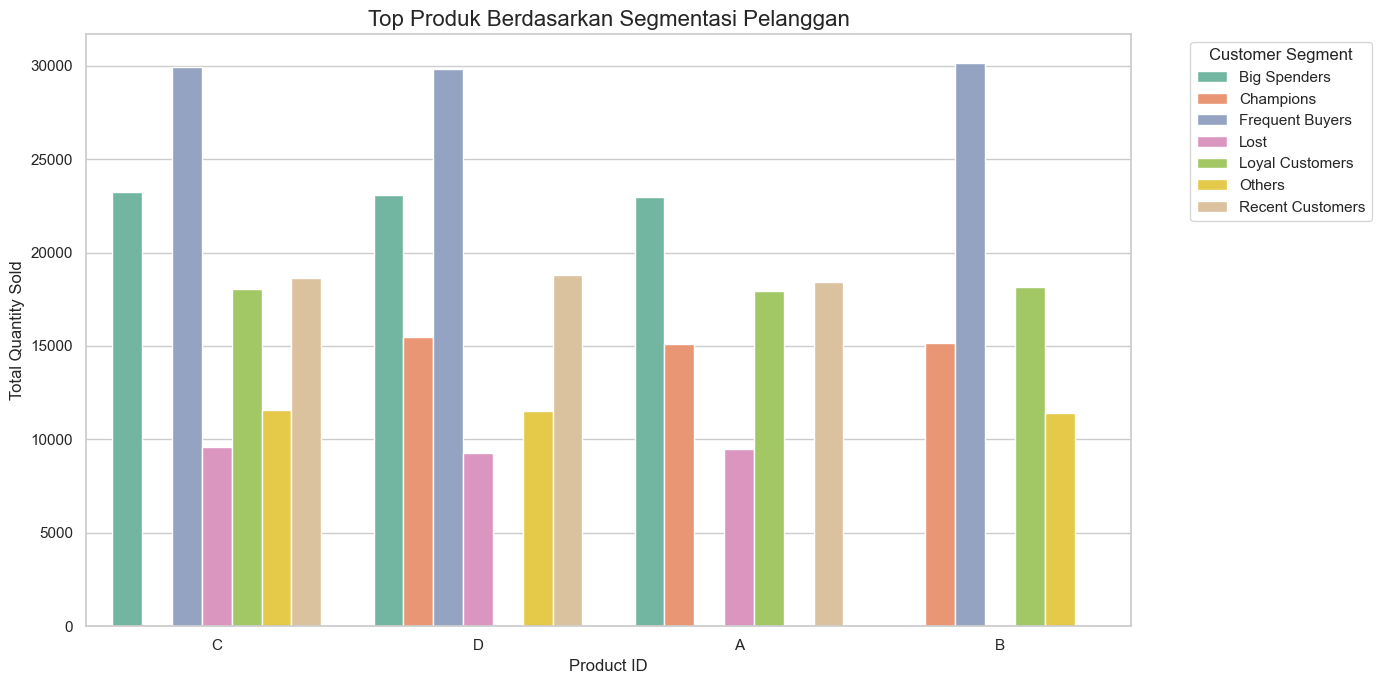

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style biar clean dan enak dilihat
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot barplot
sns.barplot(
    data=top_products_per_segment,
    x="productid",
    y="quantity",
    hue="Segment",
    palette="Set2"
)

# Tambahin judul & label
plt.title("Top Produk Berdasarkan Segmentasi Pelanggan", fontsize=16)
plt.xlabel("Product ID")
plt.ylabel("Total Quantity Sold")
plt.legend(title="Customer Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat pivot table untuk heatmap
heatmap_data = df_segmented.groupby(['Segment', 'productid'])['quantity'].sum().reset_index()
pivot_table = heatmap_data.pivot(index='Segment', columns='productid', values='quantity')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=',.0f', cmap='YlGnBu')
plt.title('Heatmap Quantity Produk vs Segment Pelanggan', fontsize=14)
plt.xlabel('Product ID')
plt.ylabel('Customer Segment')
plt.tight_layout()
plt.show()


KeyError: 'Segment'